# GPN Intelligence Cup 2020: Data Science

## 1. Анализ исходных данных 

In [235]:
import pandas as pd
import numpy as np

### 1.1. Анализ данных по продажам

In [46]:
sales = pd.read_parquet('sales.parquet')

In [119]:
sales.shape

(5081459, 6)

In [130]:
sales.head(15)

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0
5,2146-01-01,1,Рейдеры,5,Броня и одежда,2.0
6,2146-01-01,1,Рейдеры,5,Бензак,5510.0
7,2146-01-01,1,Рейдеры,5,Солярка,238.0
8,2146-01-01,2,Рейдеры,4,Ядер-Кола,37.0
9,2146-01-01,2,Рейдеры,4,Съедобный хлам,115.0


In [124]:
sales.isna().values.any() # Отлично, пропусков в данных по продажам нет

False

In [128]:
sales['owner'].value_counts()

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [129]:
sales['number_of_counters'].value_counts()

6     2358414
8     1151018
4      815438
10     389423
5      106718
9       81733
12      77329
7       65052
11      12201
14       6778
13       5632
3        3972
1        2909
16        919
17        893
15        855
2         845
18        517
19        510
20        200
21         81
22         15
23          7
Name: number_of_counters, dtype: int64

In [131]:
sales['goods_type'].value_counts()

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [135]:
sales['total_items_sold'].value_counts()[-1] # проверить на отрицательные значения

10

### 1.2. Анализ данных по характеристикам магазинов

In [136]:
shops = pd.read_parquet('shops.parquet')

In [138]:
shops.shape

(845, 8)

In [139]:
shops.head(5) # замечен первый None 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [143]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [147]:
shops['year_opened'].value_counts()[:2] # описать, как мы интерпретируем значения 

 2139    94
-1       63
Name: year_opened, dtype: int64

In [184]:
shops['shop_type'].value_counts()

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [156]:
shops['neighborhood'].value_counts()

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

### 1.3. Анализ данных о разбивке городов по локациям

In [151]:
cities = pd.read_parquet('cities.parquet')

In [153]:
cities.shape

(15, 2)

In [152]:
cities

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь
5,Пасть,Свистящие Степи
6,Аэропорт,Скалистый Могильник
7,Равнина Маяка,Радиоактивная Пустошь
8,Дизельные Жилы,Свистящие Степи
9,Темница,Радиоактивная Пустошь


## 2. Выбор информативных признаков  

In [ ]:
делаю таблицу id - good_type

In [203]:
sample = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})

In [199]:
test = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})

In [200]:
test

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
...,...,...,...
8269,844,Патроны,483466.0
8270,844,Солярка,5589807.0
8271,844,Съедобный хлам,274576.0
8272,844,Хлам,131561.0


In [216]:
goods = set(test['goods_type'])

In [226]:
df1 = sales.groupby(['shop_id'], as_index=False).aggregate({'total_items_sold' : 'sum'})['shop_id']

In [227]:
for type in goods:
    df2 = sales[sales['goods_type'] == type].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    df2 = df2.rename(columns={'total_items_sold': type})
    df1 = pd.merge(left=df1, right=df2, left_on='shop_id', right_on='shop_id',  how='outer')

In [228]:
df1

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,NaN,NaN,NaN,NaN,35.0,11647666.0,1077.0,1351.0,NaN,NaN
1,1,1236.0,NaN,NaN,NaN,1548661.0,298.0,9079168.0,20340.0,5321.0,NaN,NaN
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,NaN,NaN,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,48415.0,26988.0,96224.0,405407.0,3563307.0,15534.0,17566124.0,245789.0,112601.0,163479.0,11152.0
841,841,31991.0,17683.0,78876.0,551027.0,3484279.0,19501.0,19530586.0,269893.0,95302.0,150300.0,13614.0
842,842,45371.0,34233.0,193496.0,661920.0,4775790.0,38839.0,21984118.0,491745.0,114614.0,383469.0,26467.0
843,843,51099.0,17824.0,105411.0,855965.0,3479157.0,16586.0,24264734.0,335289.0,107085.0,192845.0,19941.0


In [229]:
df = df1.fillna(0)

In [230]:
df

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,0.0,0.0,0.0,0.0,35.0,11647666.0,1077.0,1351.0,0.0,0.0
1,1,1236.0,0.0,0.0,0.0,1548661.0,298.0,9079168.0,20340.0,5321.0,0.0,0.0
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,0.0,0.0,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,48415.0,26988.0,96224.0,405407.0,3563307.0,15534.0,17566124.0,245789.0,112601.0,163479.0,11152.0
841,841,31991.0,17683.0,78876.0,551027.0,3484279.0,19501.0,19530586.0,269893.0,95302.0,150300.0,13614.0
842,842,45371.0,34233.0,193496.0,661920.0,4775790.0,38839.0,21984118.0,491745.0,114614.0,383469.0,26467.0
843,843,51099.0,17824.0,105411.0,855965.0,3479157.0,16586.0,24264734.0,335289.0,107085.0,192845.0,19941.0


In [259]:
f = df.apply(np.sum, axis=1) # нормализация признаков
new_df = df.div(f.iloc[0], axis='columns')
new_df['shop_id'] = df['shop_id']
new_df

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,0.999782,0.000092,0.000116,0.000000e+00,0.000000
1,1,0.000106,0.000000,0.000000,0.000000,0.132930,0.000026,0.779314,0.001746,0.000457,0.000000e+00,0.000000
2,2,0.001852,0.000474,0.000267,0.054632,0.118317,0.000305,0.682664,0.009907,0.003433,4.046365e-03,0.000217
3,3,0.000065,0.000005,0.000000,0.000000,0.205953,0.001140,1.978405,0.002751,0.001521,4.291768e-07,0.000003
4,4,0.001187,0.001453,0.003222,0.068435,0.279699,0.001325,2.007648,0.024863,0.006863,1.390490e-02,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,0.004156,0.002317,0.008259,0.034798,0.305858,0.001333,1.507795,0.021097,0.009665,1.403228e-02,0.000957
841,841,0.002746,0.001518,0.006770,0.047298,0.299074,0.001674,1.676415,0.023166,0.008180,1.290106e-02,0.001169
842,842,0.003894,0.002938,0.016609,0.056816,0.409932,0.003334,1.887015,0.042209,0.009838,3.291520e-02,0.002272
843,843,0.004386,0.001530,0.009048,0.073472,0.298635,0.001424,2.082772,0.028780,0.009192,1.655292e-02,0.001712


,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,0.0,0.0,0.0,0.0,35.0,11647666.0,1077.0,1351.0,0.0,0.0
1,1,1236.0,0.0,0.0,0.0,1548661.0,298.0,9079168.0,20340.0,5321.0,0.0,0.0
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,0.0,0.0,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,48415.0,26988.0,96224.0,405407.0,3563307.0,15534.0,17566124.0,245789.0,112601.0,163479.0,11152.0
841,841,31991.0,17683.0,78876.0,551027.0,3484279.0,19501.0,19530586.0,269893.0,95302.0,150300.0,13614.0
842,842,45371.0,34233.0,193496.0,661920.0,4775790.0,38839.0,21984118.0,491745.0,114614.0,383469.0,26467.0
843,843,51099.0,17824.0,105411.0,855965.0,3479157.0,16586.0,24264734.0,335289.0,107085.0,192845.0,19941.0


In [215]:
merged_inner = pd.merge(left=df1, right=df2, left_on='shop_id', right_on='shop_id',  how='outer')
merged_inner

,total_items_sold,tis
shop_id,,
0,11647666.0,NaN
1,9079168.0,NaN
2,7953184.0,636472.0
3,23048831.0,NaN
4,23389524.0,797282.0
...,...,...
840,17566124.0,405407.0
841,19530586.0,551027.0
842,21984118.0,661920.0


In [193]:
p = sales[sales['goods_type'] == 'Броня и одежда'].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})

In [168]:
 sales['shop_id'][1]

0

In [ ]:
from collections import defaultdict 

In [167]:
for i in range(1, 8275):
    d[sales['shop_id'][i]].append([sales['goods_type'][i],sales['total_items_sold'][i]])

KeyboardInterrupt: 

In [163]:
for row in sales.rows:
    print(row)
    break

AttributeError: 'DataFrame' object has no attribute 'rows'

In [162]:
set(sales['goods_type'])

{'Бензак',
 'Броня и одежда',
 'Жидкости для тачки',
 'Медпрепараты и еда',
 'Модификации тачки',
 'Оружие',
 'Патроны',
 'Солярка',
 'Съедобный хлам',
 'Хлам',
 'Ядер-Кола'}

In [ ]:
import pandas as pd
inp = [{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}]
df = pd.DataFrame(inp)
print df

In [ ]:
 c1   c2
0  10  100
1  11  110
2  12  120

In [ ]:
for row in df.rows:
   print row['c1'], row['c2']

In [76]:
shops['is_on_the_road'] = shops['is_on_the_road'].replace("нет",0)
shops['is_on_the_road'] = shops['is_on_the_road'].replace("да",1)

In [77]:
shops['is_with_the_well'] = shops['is_with_the_well'].replace("да", 1)
shops['is_with_the_well'] = shops['is_with_the_well'].replace("нет", 0)

In [78]:
shops['is_with_additional_services'] = shops['is_with_additional_services'].replace("да", 1)
shops['is_with_additional_services'] = shops['is_with_additional_services'].replace("нет", 0)

In [79]:
shops = shops[['shop_id', 'year_opened', 'is_on_the_road', 'is_with_the_well', 'is_with_additional_services', 'shop_type']]

In [80]:
data = shops.to_numpy()

In [96]:
from sklearn.cluster import DBSCAN
 

dbscan = DBSCAN(eps=10, min_samples=5)
 
dbscan.fit(data)
 
# Готово! Распечатаем метки принадлежности к кластерам
print(dbscan.labels_)


[ 0  0  1  2  2  3  1  4  0  1  1  1  7  1  0  0  1  0  4  1  0  0  1  0
  1  0  1  1  0  1  1  1  1  0  0  0  1  0  1 -1  5  1  5  0  1  0  2  1
  1  0  1  1  4  0  0  1  1  1  0 -1  0  0  1  7  1  2  0  1  0  1  1  1
  1  1  1  1  0  4  1  1  0  1  0  1  1  3  1  0 -1  1  1  1  1 -1  1  0
  3  3  1  1  4  7  1  0  5  6  0  1  3  1  0  0  0 -1  1  1  1  1  0  1
  1  0  1  1  1  3  1  0  1  1  0  1  0  1  4  1  1  1  1  1  1  1  0  1
  0  1  1  1  4  1  1  1  1  0  1  1  1  1 -1  1  1  0  0  0  1  0  1  0
  5  1  0  0  1  3  0 -1  1  4  1  0  1  1  1 -1  1  1  1  1  1  1  1  3
  1  1  1  0 -1  1  1  3  1 -1  1  2  3  1  0  0 -1 -1  1 -1  0  0  0  1
  1  0  4 -1  3 -1  1  1  3  0  1  1  0  4  1  1  0  0  0  1 -1  5  4  1
  3  1  4  1  0  1  1  1  1 -1  2  1  1  1  0 -1  1  1  1  5  1  1  1  1
 -1  1  1  4  1  1  1  1  1  1  0  5  1  1  1  0  1  1  0  1  2  1  1  3
  0  0  1  0  2 -1  3  1  1  1 -1 -1  1  3  1  1  1  1  4  5  0  0  1  5
  0  0  1  3  0 -1  0  1  1  1 -1  3  1  1  1  1  1

In [114]:
len(set(dbscan.labels_))

9

In [97]:
s = set(dbscan.labels_)

In [99]:
color = ['r', 'g', 'b', 'y', 'm', 'c', 'w', 'k']

In [103]:
d = dict()

In [105]:
for i in s:
    d[i]=color[i]

In [106]:
d

{0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm', 5: 'c', 6: 'w', 7: 'k', -1: 'k'}

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(data)
pca_2d = pca.transform(data)

In [93]:
pca_2d.shape[0]

845

In [95]:
pca_2d[1]

array([-126.01203819, -209.80391217])

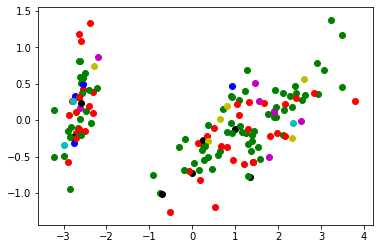

In [111]:
for i in range(0, pca_2d.shape[0]):
    plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c= d[dbscan.labels_[i]])

plt.show()

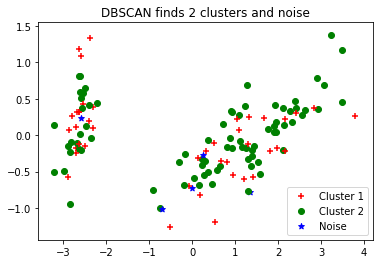

In [109]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
pca = PCA(n_components=2).fit(iris.data)
pca_2d = pca.transform(iris.data)
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
 
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Noise'])
plt.title('DBSCAN finds 2 clusters and noise')
plt.show()

In [26]:
 from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
corpus = [     'This is the first document.',
     'This document is the second document.',
    'And this is the third one.',
   'Is this the first document?',
 ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [28]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [31]:
from gensim.models import Word2Vec

In [32]:
print(decipher(sample_dictionary_corpus, sample_corpus))

NameError: name 'decipher' is not defined

In [34]:
from gensim.models import Word2Vec
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(sentences, min_count=1)



In [37]:
model.wv